In [1]:
import datarobot as dr
import pandas as pd
import numpy as np
import datetime as dt
import os
import re 
from importlib import reload
from ts_metrics import *
from ts_pre_processing import *
from ts_calendar import *
from ts_projects import *
from ts_modeling import *
from ts_clustering import *
from ts_data_quality import *
from ts_predictions import *

ModuleNotFoundError: No module named 'src'

In [2]:
pd.set_option('display.max_colwidth', -1)

### Connect to API Client

In [3]:
# Connect to DRClient
dr.Client()

### Set Working Directory and Import Dataset

In [55]:
# get wd
path = '/Users/justin.swansburg/Desktop/Temp/Demo Scripts/DR TS POC/'
cwd = os.chdir(path)

# import dataset
training = pd.read_csv('time_series_poc_certification_training.csv', parse_dates = True, engine='c')
training = dataset_reduce_memory(training)

### Create dictionary of default params

In [56]:
# Set defaults
target = 'Sales'
date_col = 'Date'
series_id = 'Department'
kia = ['Marketing', 'Pct_Promotional', 'Department_Size', 'DestinationEvent']
num_backtests = 3
validation_duration = 60
holdout_duration = 30
disable_holdout = True
metric = 'RMSE'
use_time_series=True
fd_start = 1
fd_end = 7
fdw_start = -28
fdw_end = 0
max_date = pd.to_datetime('12-31-2013') #pd.to_datetime(training[date_col]).max()

# Create TS Settings
ts_settings = {'max_date':max_date, 'known_in_advance':kia, 'num_backtests':num_backtests, 
               'validation_duration':validation_duration, 'holdout_duration':holdout_duration,
               'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end}

### Check data quality

In [57]:
ts_describe = DataQualityCheck(training, ts_settings)

Running all data quality checks...

There are 18000 rows and 14 columns
There are 24 series
The data spans from  2012-04-01 00:00:00 to 2014-10-31 00:00:00
Data fails hierarchical check! No hierarchical blueprints will run.
The minimum target value is zero. Zero-Inflated blueprints will run.
No new series were introduced after the start of the training data
No series were removed before the end of the training data
No duplicate timestamps detected within any series
No leading or trailing zeros detected within series
100.00% of series have at least one missing time step.
0.00% of the rows are missing a target value
0.00% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Series are irregularly spaced. Projects will only be able to run in row-based mode!
Detected periodicity: weekly


### Series are irregularly spaced -- let's fix that

In [58]:
training = fill_missing_dates(training, ts_settings)

In [59]:
# Rerun our data quality check
ts_describe = DataQualityCheck(training, ts_settings)

Running all data quality checks...

There are 22638 rows and 14 columns
There are 24 series
The data spans from  2012-04-01 00:00:00 to 2014-10-31 00:00:00
Data passes hierarchical check! DataRobot hierarchical blueprints will run if you enable cross series features.
The minimum target value is zero. Zero-Inflated blueprints will run.
No new series were introduced after the start of the training data
No series were removed before the end of the training data
No duplicate timestamps detected within any series
No leading or trailing zeros detected within series
0.00% of series have at least one missing time step.
20.49% of the rows are missing a target value
0.00% series have zeros in more than 99.00% or more of the rows
Project Timestep:  1   day
There are no uncommon time steps
Timesteps are regularly spaced. You will be able to run projects in either time-based or row-based mode
Detected periodicity: weekly


### Now that's fixed let's plot the data

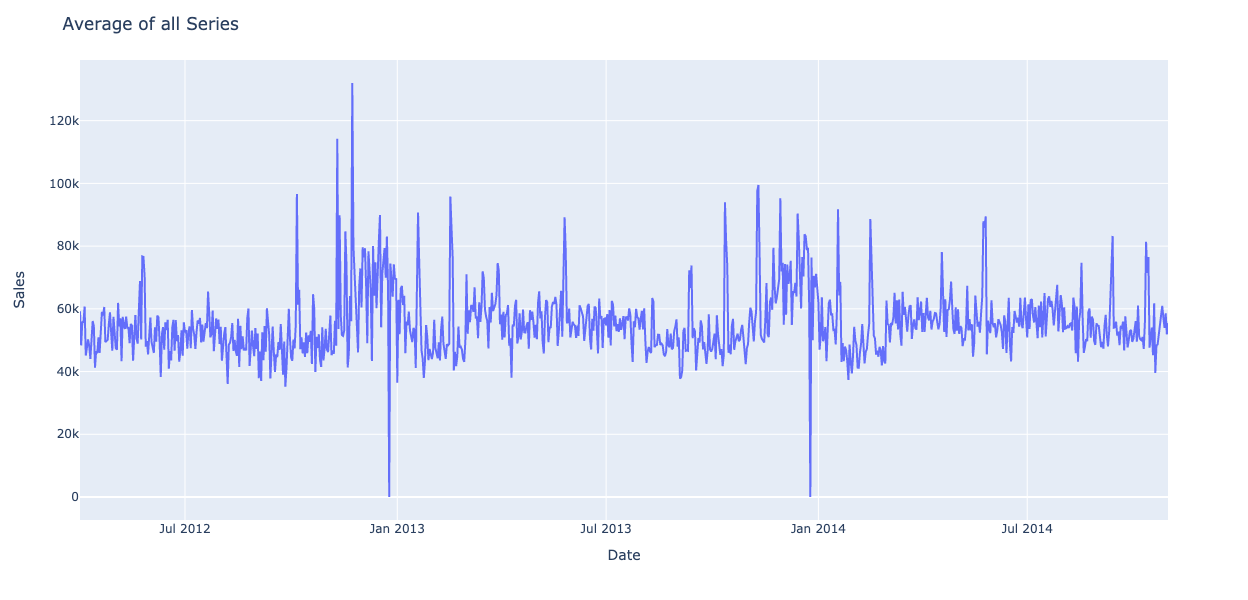

In [25]:
# Plot our average target over time
plot_series_average(training, ts_settings)

### These spikes and dips may be signs of Holidays

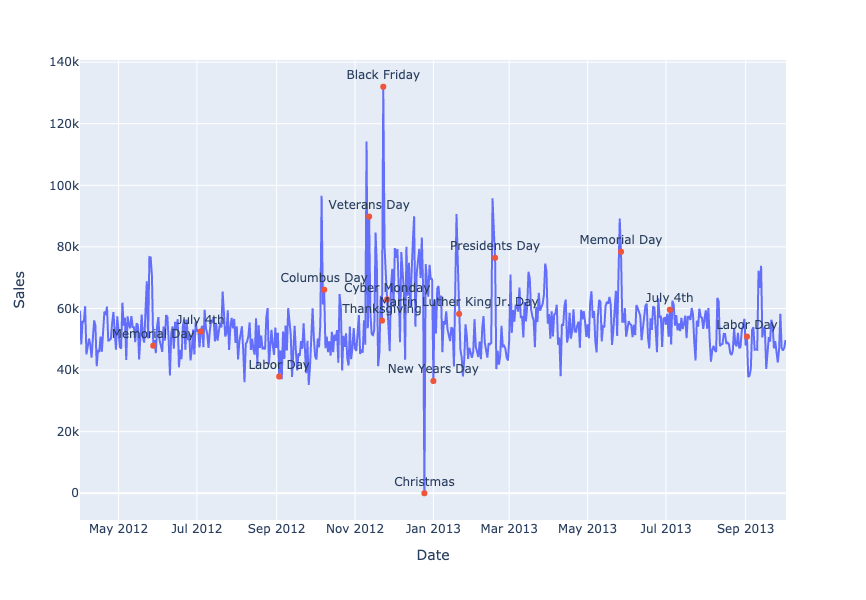

In [26]:
# Create and plot a Holiday calendar
plot_ts_calendar(training, ts_settings, calendar=None)

#Note: you don't need to have an already created calendar

### Stores look to be closed on Christmas day. Let's drop these rows

In [27]:
xmas = [pd.to_datetime('12-25-2012'), pd.to_datetime('12-25-2013')]
training = training.loc[~training[date_col].isin(xmas),:]

In [44]:
# Optionally create a calendar and add or remove events
additional_events = {'Date':['2016-06-19','2017-06-18','2018-06-17','2019-06-16','2020-06-21','2021-06-20'], 
                     'Event':['Fathers Day']*6}
#create_ts_calendar(training, ts_settings, additional_events=pd.DataFrame(additional_events))

In [46]:
# Add a calendar to our dictionary of default parameters
cal = create_and_upload_ts_calendar(training, ts_settings) #if you don't specify a calendar, one will be created
ts_settings['calendar_id'] = cal.id

Calendar file has been created
Calendar file 5e17f34cb26a0c1e9bc0d599 has been uploaded


### What about individual series?

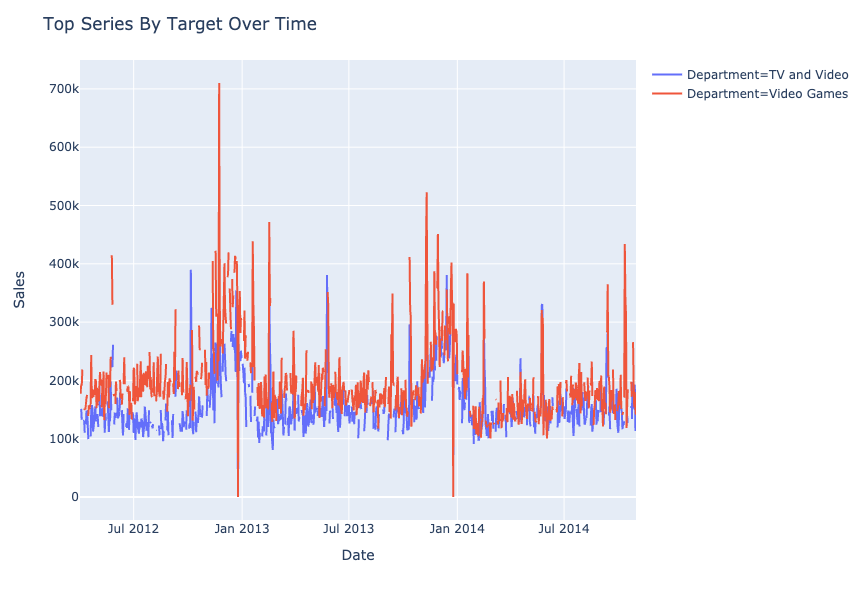

In [69]:
# Top 2 series
plot_individual_series(training, ts_settings, n=2, top=True)

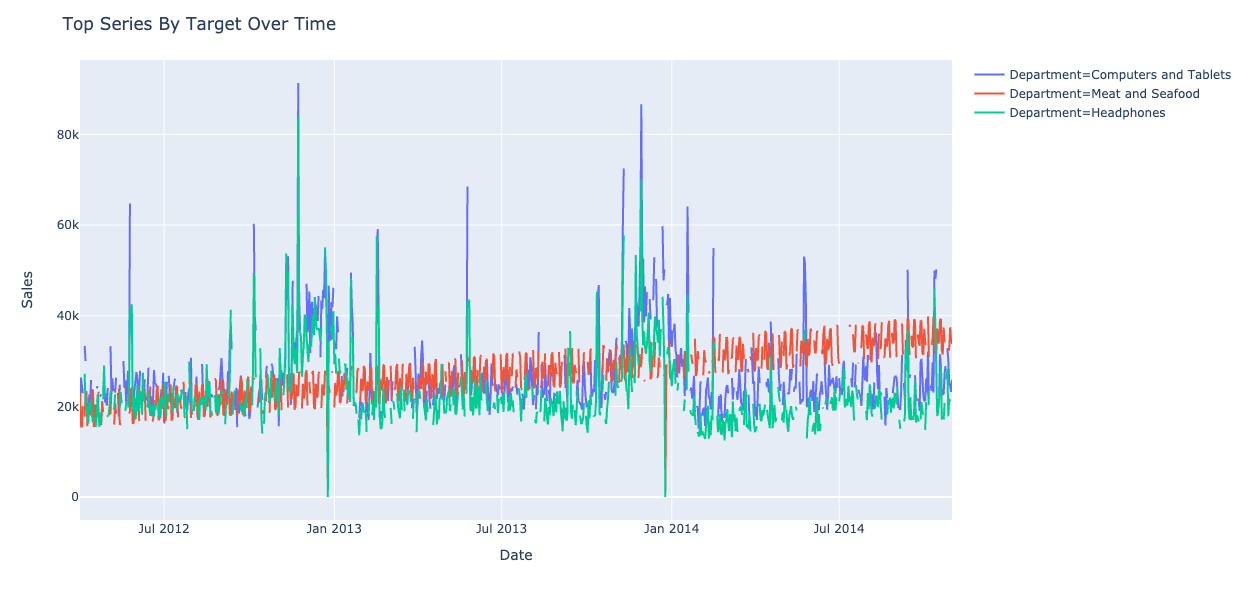

In [70]:
# Bottom 3 series
plot_individual_series(training, ts_settings, n=3, top=False)

### Eeeek. Some of these series look pretty different. Let's try splitting similar series out into separate clusters

#### But how do we cluster???

Testing 2 to 6 clusters
For n_clusters = 2, silhouette score is 0.6725615224497319
For n_clusters = 3, silhouette score is 0.8830616305825867
For n_clusters = 4, silhouette score is 0.7683127030478939
For n_clusters = 5, silhouette score is 0.7511673923886145
For n_clusters = 6, silhouette score is 0.7625179773485747
optimal n_clusters = 3, max silhouette score is 0.8830616305825867


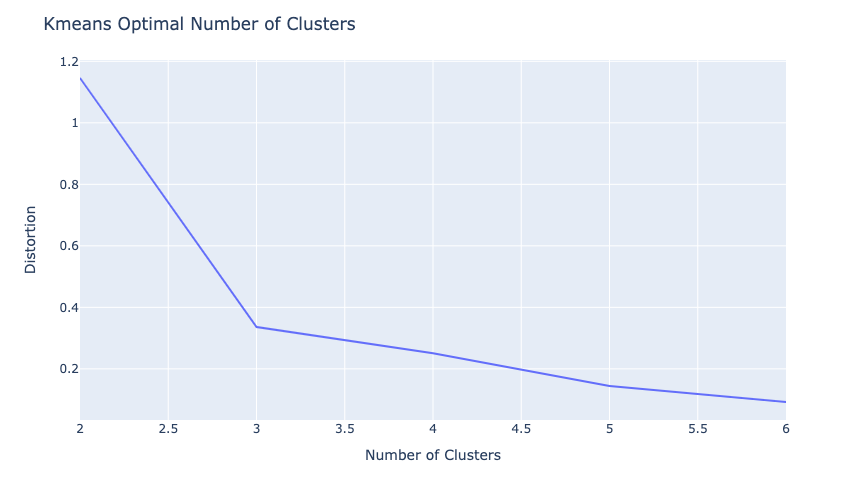

In [14]:
# Series clustering
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
split_method=None
n_clusters=None
max_clusters=6
plot=True

df_w_clusters =  add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    split_method=split_method,
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=True)

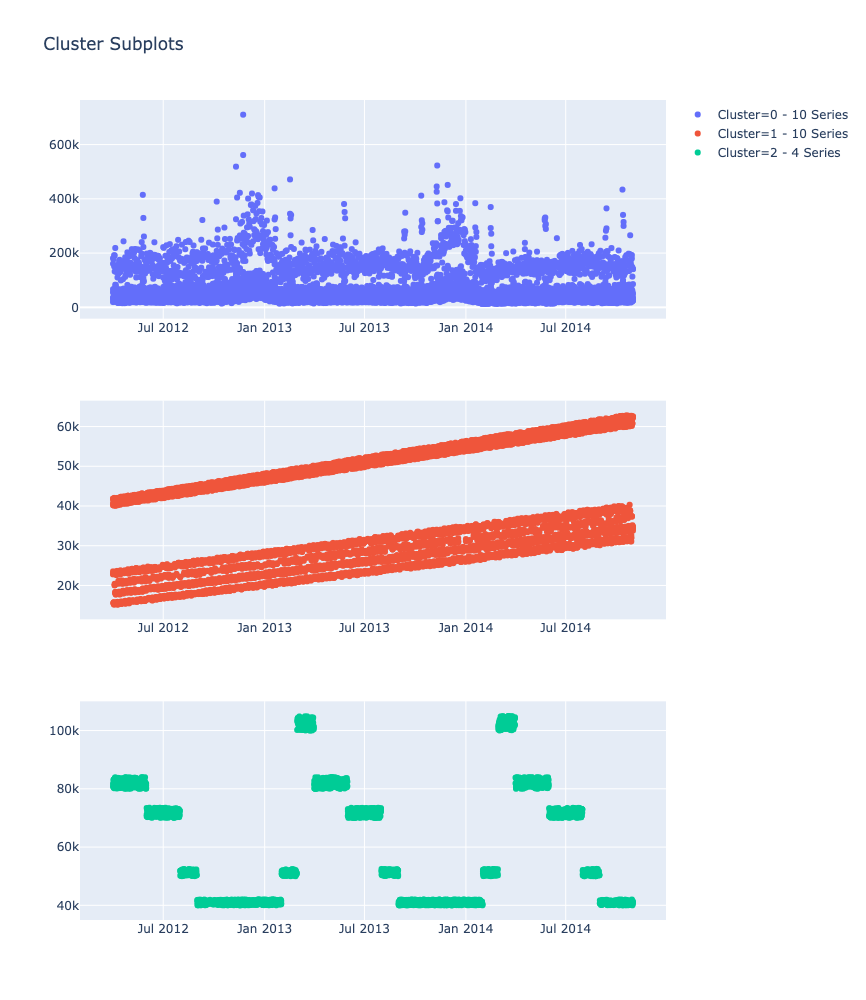

In [15]:
plot_clusters(df_w_clusters, ts_settings)

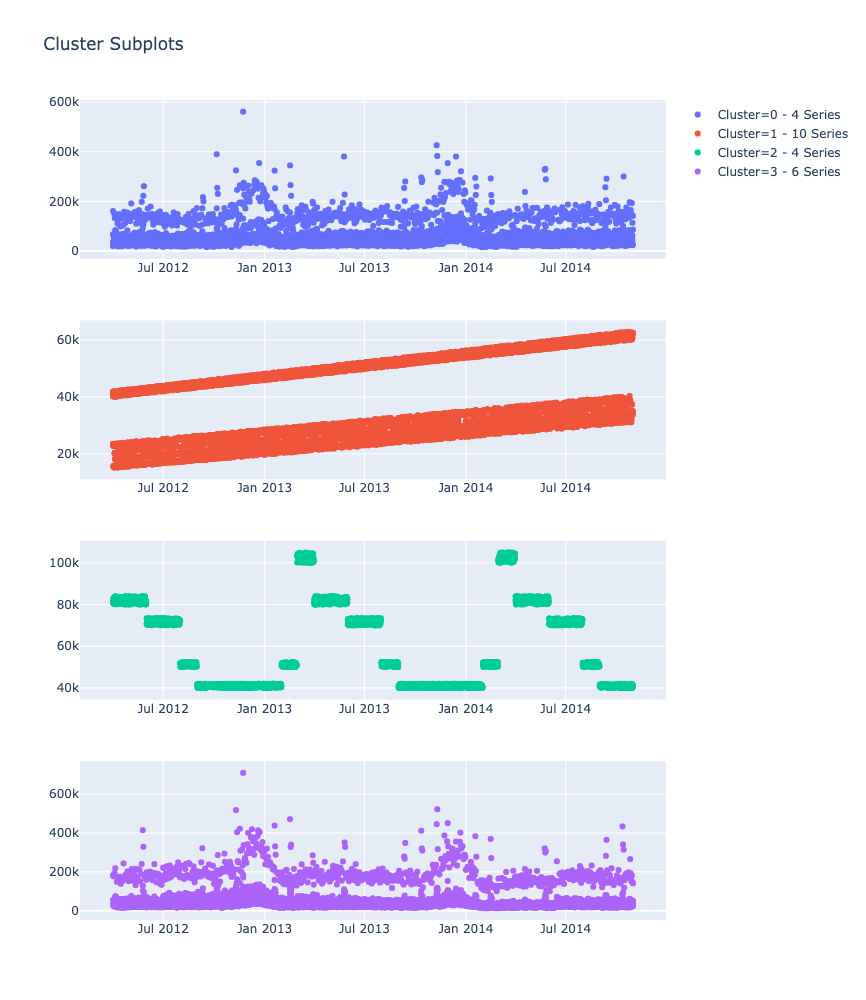

In [16]:
# We can force 4 clusters
method='correlation'
nlags=None
alpha=None
scale=True
scale_method=None
n_clusters=4
max_clusters=None
plot=True

df_w_clusters =  add_cluster_labels(training, 
                                    ts_settings, 
                                    method=method,
                                    scale=scale,
                                    scale_method=scale_method,
                                    alpha=alpha,
                                    nlags=nlags, 
                                    n_clusters=n_clusters, 
                                    max_clusters=max_clusters, 
                                    plot=True)

plot_clusters(df_w_clusters, ts_settings)

### Hmmm. I don't love these clusters. Should this be split differently? Let's try out another strategy

In [1]:
method='pacf'
nlags=7
alpha=0.025 #Set to None if you want keep raw coefficeints
scale=True
scale_method='normalize'
n_clusters=None
max_clusters=6
plot=True

df_w_clusters =  add_cluster_labels(training, 
                                       ts_settings, 
                                       method=method,
                                       scale=scale,
                                       scale_method=scale_method,
                                       alpha=alpha,
                                       nlags=nlags, 
                                       n_clusters=n_clusters, 
                                       max_clusters=max_clusters, 
                                       plot=False)

plot_clusters(df_w_clusters, ts_settings)

NameError: name 'add_cluster_labels' is not defined

### We could also test out other strategies like splitting series by level, series ID, performance, or periodicity, but this seems good enough for now

#### Do we need to do anything else before we start building models?

### Add cross series features

In [18]:
df_w_clusters = create_cross_series_features(df_w_clusters, 
                                             group=[date_col,'Cluster'], 
                                             cols=[target], 
                                             funcs=['mean','std'])
df_w_clusters.head(2)

Department       Date    Sales  Department_Size  Num_Employees  \
0  Athletic Clothing 2012-04-01  80874.0  2060.0           31.0            
1  Bathing Suits     2012-04-01  81787.0  2040.0           31.0            

   Returns_Pct  Num_Customers  Pct_On_Sale  \
0  0.760756     371.0          8.660916      
1  0.760756     371.0          8.660916      

                                                             Marketing  \
0  In Store Credit Card Signup Discount; Spring Product Email ID1.6361   
1  In Store Credit Card Signup Discount; Spring Product Email ID1.6361   

  DestinationEvent  Pct_Promotional  Econ_ChangeGDP  EconJobsChange  \
0  No               0.029439         0.780263       NaN               
1  No               0.029439         0.780263       NaN               

   AnnualizedCPI  Cluster  Sales_mean   Sales_std  Num_Customers_mean  \
0 -0.025092       0        81330.5     645.588491  371.0                
1 -0.025092       0        81330.5     645.588491  371.0                

   Num_Customers_std  
0  0.0                
1  0.0

### Okay now let's finally build some models

In [23]:
# Build separate projects by forecast distance, feature derivation window, and/or cluster
fdws=[(-28,0),(-62,0)]
fds = [(1,30),(31,60)]
projects = create_dr_projects(df_w_clusters, 
                             ts_settings, 
                             prefix='TS',
                             split_col='Cluster', 
                             fdws=fdws, 
                             fds=fds)


Kicking off 16 projects

Building Next Project 
...

Project TS_FD:1-30_FDW:-28_Cluster-0 Created...
Building Next Project 
...

Project TS_FD:31-60_FDW:-28_Cluster-0 Created...
Building Next Project 
...

Project TS_FD:1-30_FDW:-62_Cluster-0 Created...
Building Next Project 
...

Project TS_FD:31-60_FDW:-62_Cluster-0 Created...
Building Next Project 
...

Project TS_FD:1-30_FDW:-28_Cluster-1 Created...
Building Next Project 
...

Project TS_FD:31-60_FDW:-28_Cluster-1 Created...
Building Next Project 
...

Project TS_FD:1-30_FDW:-62_Cluster-1 Created...
Building Next Project 
...

Project TS_FD:31-60_FDW:-62_Cluster-1 Created...
Building Next Project 
...

Project TS_FD:1-30_FDW:-28_Cluster-2 Created...
Building Next Project 
...

Project TS_FD:31-60_FDW:-28_Cluster-2 Created...
Building Next Project 
...

Project TS_FD:1-30_FDW:-62_Cluster-2 Created...
Building Next Project 
...

Project TS_FD:31-60_FDW:-62_Cluster-2 Created...
Building Next Project 
...

Project TS_FD:1-30_FDW:-28_Cl

In [24]:
wait_for_jobs_to_process(projects)

There are 28 jobs still processing
There are 18 jobs still processing
There are 4 jobs still processing
There are 10 jobs still processing
There are 13 jobs still processing
There are 2 jobs still processing
There are 3 jobs still processing
There are 2 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
There are 1 jobs still processing
There are 3 jobs still processing
All jobs have finished processing...


In [25]:
# No need to compute backtests since we set n_backtests = 1
compute_backtests(projects, n_models=5, data_subset='allBacktests', include_blenders=True, metric='RMSE')

All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-28_Cluster-0
All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-28_Cluster-0
All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-62_Cluster-0
All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-62_Cluster-0
All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-28_Cluster-1
All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-28_Cluster-1
All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-62_Cluster-1
Computing backtests for model 5e268e107e16dc5d1f0ad632 in Project TS_FD:31-60_FDW:-62_Cluster-1
All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-62_Cluster-1
All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-28_Cluster-2
All available backtests hav

In [49]:
project_scores = get_or_request_backtest_scores(projects, 
                                               n_models=1, 
                                               data_subset='allBacktests', 
                                               include_blenders=True, 
                                               metric='RMSE')

Scores for all 16 projects have been computed


In [50]:
project_scores

Project_Name                Project_ID  \
0   TS_FD:31-60_FDW:-62_Cluster-3  5e268ea649295006db0779d7   
1    TS_FD:1-30_FDW:-62_Cluster-3  5e268d9e9ec69d0733ed8622   
2   TS_FD:31-60_FDW:-28_Cluster-3  5e268ca949295006db0779d1   
3    TS_FD:1-30_FDW:-28_Cluster-3  5e268bcb9ec69d0699ed86a2   
4   TS_FD:31-60_FDW:-62_Cluster-2  5e268ac29ec69d068ced8684   
5    TS_FD:1-30_FDW:-62_Cluster-2  5e2689b8492950067d0779f4   
6   TS_FD:31-60_FDW:-28_Cluster-2  5e2688b7492950067d0779e6   
7    TS_FD:1-30_FDW:-28_Cluster-2  5e2687a549295006db07799f   
8   TS_FD:31-60_FDW:-62_Cluster-1  5e26866a9ec69d06d2ed861e   
9    TS_FD:1-30_FDW:-62_Cluster-1  5e2685659ec69d0733ed85b0   
10  TS_FD:31-60_FDW:-28_Cluster-1  5e26845749295006670779a6   
11   TS_FD:1-30_FDW:-28_Cluster-1  5e2683519ec69d0733ed8591   
12  TS_FD:31-60_FDW:-62_Cluster-0  5e26825e49295006db07795c   
13   TS_FD:1-30_FDW:-62_Cluster-0  5e268183492950067d0779b9   
14  TS_FD:31-60_FDW:-28_Cluster-0  5e268094492950066707798f   
15   TS_FD:1-30_FDW:-28_Cluster-0  5e267fa74929500658077998   

                    Model_ID  \
0   5e2691e27e16dc68a00ad6c1   
1   5e2691767e16dc67b70ad6b4   
2   5e268f105a5fe64f6fe323a6   
3   5e268f327e16dc61400ad668   
4   5e268df25a5fe64b94e32373   
5   5e268d1f5a5fe6462ee32356   
6   5e268cbf7e16dc581a0ad601   
7   5e268cae5a5fe644a8e32342   
8   5e268789046af516c7140910   
9   5e268652f186b5ab6e0181b2   
10  5e26854801e6ce76ef22d481   
11  5e26898a7e16dc4d190ad558   
12  5e2684815a5fe62862e3218b   
13  5e26846c5a5fe6280fe32183   
14  5e2682a37e16dc355a0ad3e8   
15  5e268084f186b5fb71ccc1a5   

                                           Model_Type  \
0                                         AVG Blender   
1                                         AVG Blender   
2   eXtreme Gradient Boosted Trees Regressor with ...   
3                                         AVG Blender   
4                                         AVG Blender   
5     Ridge Regressor with Forecast Distance Modeling   
6                                         AVG Blender   
7                                         AVG Blender   
8   Ridge Regressor with Forecast Distance Modelin...   
9   Ridge Regressor with Forecast Distance Modelin...   
10    Ridge Regressor with Forecast Distance Modeling   
11                                        AVG Blender   
12  Light Gradient Boosting on ElasticNet Predicti...   
13                                        AVG Blender   
14  Light Gradient Boosting on ElasticNet Predicti...   
15    Ridge Regressor with Forecast Distance Modeling   

                             Featurelist  Backtest_1_RMSE  Backtest_1_MASE  \
0   With Differencing (average baseline)        839.20313          0.56375   
1                 DR Reduced Features M8        832.54263          0.73853   
2                 DR Reduced Features M8        846.60698          0.56486   
3   With Differencing (average baseline)        842.97554          0.75100   
4                 DR Reduced Features M9        540.62751          0.50095   
5                DR Reduced Features M16        535.06529          0.74517   
6             With Differencing (latest)        525.49017          0.48644   
7             With Differencing (latest)        519.77246          0.69618   
8                        No Differencing      11417.09533          0.49153   
9                        No Differencing       8870.19018          0.34326   
10                       No Differencing      10951.09909          0.44952   
11             With Differencing (7 day)       8891.56288          0.34628   
12               DR Reduced Features M20        704.57185          0.04670   
13                       No Differencing        669.55152          0.19045   
14               DR Reduced Features M20        679.71542          0.04494   
15                       No Differencing        675.45370          0.18998   

    Backtest_1_Theils_U  Backtest_1_SMAPE  Backtest_1_R_Squared  \
0               0.53667           1.1898

In [51]:
scores_best = filter_best_fdw_scores(project_scores, col_error='All_Backtests_RMSE')
scores_best

Project_Name                Project_ID  \
15   TS_FD:1-30_FDW:-28_Cluster-0  5e267fa74929500658077998   
14  TS_FD:31-60_FDW:-28_Cluster-0  5e268094492950066707798f   
11   TS_FD:1-30_FDW:-28_Cluster-1  5e2683519ec69d0733ed8591   
8   TS_FD:31-60_FDW:-62_Cluster-1  5e26866a9ec69d06d2ed861e   
7    TS_FD:1-30_FDW:-28_Cluster-2  5e2687a549295006db07799f   
6   TS_FD:31-60_FDW:-28_Cluster-2  5e2688b7492950067d0779e6   
1    TS_FD:1-30_FDW:-62_Cluster-3  5e268d9e9ec69d0733ed8622   
0   TS_FD:31-60_FDW:-62_Cluster-3  5e268ea649295006db0779d7   

                    Model_ID  \
15  5e268084f186b5fb71ccc1a5   
14  5e2682a37e16dc355a0ad3e8   
11  5e26898a7e16dc4d190ad558   
8   5e268789046af516c7140910   
7   5e268cae5a5fe644a8e32342   
6   5e268cbf7e16dc581a0ad601   
1   5e2691767e16dc67b70ad6b4   
0   5e2691e27e16dc68a00ad6c1   

                                           Model_Type  \
15    Ridge Regressor with Forecast Distance Modeling   
14  Light Gradient Boosting on ElasticNet Predicti...   
11                                        AVG Blender   
8   Ridge Regressor with Forecast Distance Modelin...   
7                                         AVG Blender   
6                                         AVG Blender   
1                                         AVG Blender   
0                                         AVG Blender   

                             Featurelist  Backtest_1_RMSE  Backtest_1_MASE  \
15                       No Differencing        675.45370          0.18998   
14               DR Reduced Features M20        679.71542          0.04494   
11             With Differencing (7 day)       8891.56288          0.34628   
8                        No Differencing      11417.09533          0.49153   
7             With Differencing (latest)        519.77246          0.69618   
6             With Differencing (latest)        525.49017          0.48644   
1                 DR Reduced Features M8        832.54263          0.73853   
0   With Differencing (average baseline)        839.20313          0.56375   

    Backtest_1_Theils_U  Backtest_1_SMAPE  Backtest_1_R_Squared  \
15              0.13435           1.35213              -0.56883   
14              0.04171           1.36279              -0.58869   
11              0.27093           8.87855               0.97771   
8               0.40460          10.55208               0.96324   
7               0.63902           1.25218               0.97110   
6               0.46897           1.28290               0.97046   
1               0.68449           1.18716               0.20183   
0               0.53667           1.18985               0.18900   

                         All_Backtests_RMSE           All_Backtests_MASE  \
15       [675.4537, 1010.26226, 1358.43041]  [0.18998, 0.12564, 0.27756]   
14       [679.71542, 960.16396, 1397.52939]  [0.04494, 0.05521, 0.10268]   
11    [8891.56288, 9621.73912, 13874.64541]  [0.34628, 0.69656, 0.64795]   
8   [11417.09533, 15588.99232, 16614.39879]  [0.49153, 0.83247, 0.85562]   
7         [519.77246, 492.21587, 512.75115]  [0.69618, 0.63365, 0.68741]   
6         [525.49017, 498.90528, 508.46062]   [0.48644, 0.45036, 0.4285]   
1          [832.54263, 848.0812, 821.22641]  [0.73853, 0.71117, 0.72797]   
0         [839.20313, 846.34606, 841.65563]  [0.56375, 0.60504, 0.54468]   

         All_Backtests_Theils_U             All_Backtests_SMAPE  \
15  [0.13435, 0.09158, 0.24193]     [1.35213, 1.39922, 1.36008]   
14   [0.04171, 0.0592, 0.11621]     [1.36279, 1.27084, 1.34736]   
11   [0.27093, 0.6821, 0.48986]   [8.87855, 10.13782, 15.53369]   
8     [0.4046, 0.73052, 0.6673]  [10.55208, 16.98537, 18.79411]   
7   [0.63902, 0.62546, 0.66237]      [1.25218, 1.20395, 1.3187]   
6   [0.46897, 0.45818, 0.43233]      [1.2829, 1.21324, 1.31326]   
1   [0.68449, 0.67422, 0.68894]      [1.18716, 1.22798, 1.2043]   
0    [0.53667, 0.5668, 0.52739]      [1.18985, 1.22614, 1.2339]   

         All_Backtests_R_Squared Holdout_RMSE Holdout_

In [52]:
projects_best = filter_best_fdw_projects(project_scores, projects, col_error='All_Backtests_RMSE')
projects_best

[Project(TS_FD:31-60_FDW:-62_Cluster-3),
 Project(TS_FD:1-30_FDW:-62_Cluster-3),
 Project(TS_FD:31-60_FDW:-28_Cluster-2),
 Project(TS_FD:1-30_FDW:-28_Cluster-2),
 Project(TS_FD:31-60_FDW:-62_Cluster-1),
 Project(TS_FD:1-30_FDW:-28_Cluster-1),
 Project(TS_FD:31-60_FDW:-28_Cluster-0),
 Project(TS_FD:1-30_FDW:-28_Cluster-0)]

Getting cluster accuracy...


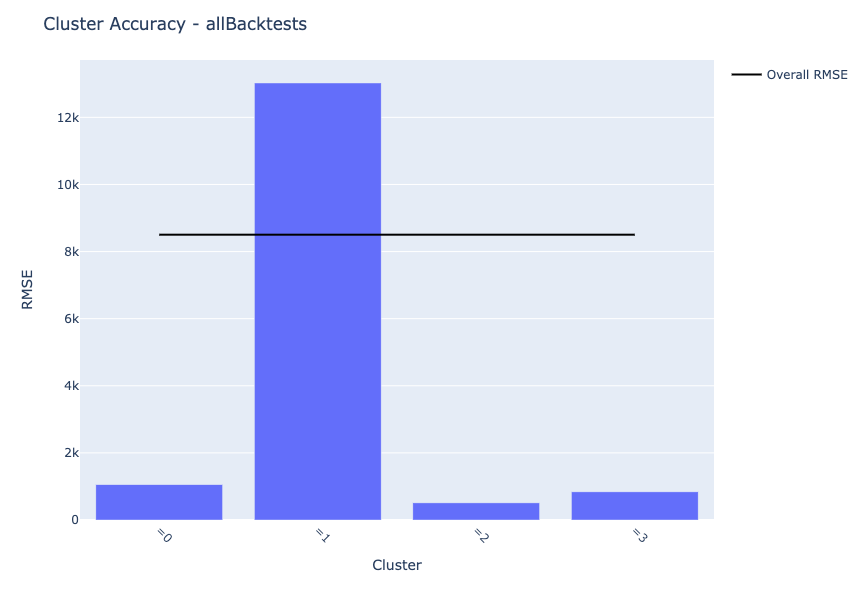

In [61]:
cluster_acc = get_cluster_acc(df_w_clusters, 
                                 projects_best, 
                                 ts_settings, 
                                 data_subset='allBacktests', 
                                 include_blenders=True, 
                                 metric='RMSE', 
                                 acc_calc=rmse)
plot_cluster_acc(cluster_acc, ts_settings, data_subset='allBacktests', metric=rmse)

### Which series in Cluster 2 is driving up the error?

Getting series accuracy...


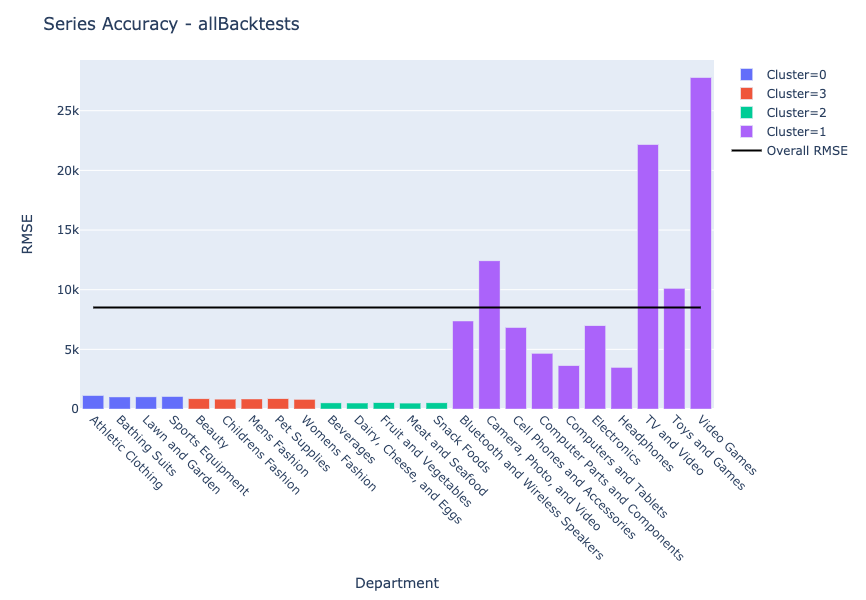

In [62]:
series_acc = get_series_acc(df_w_clusters, 
                               projects_best, 
                               ts_settings, 
                               data_subset='allBacktests', 
                               include_blenders=True, 
                               metric='RMSE', 
                               acc_calc=rmse)
plot_series_acc(series_acc, ts_settings, data_subset='allBacktests', metric=rmse)

### Only 2 series are especially problematic -- Video Games and TV and Video

#### Before we try to improve these series let's see if certain forecast distances are causing the high errors

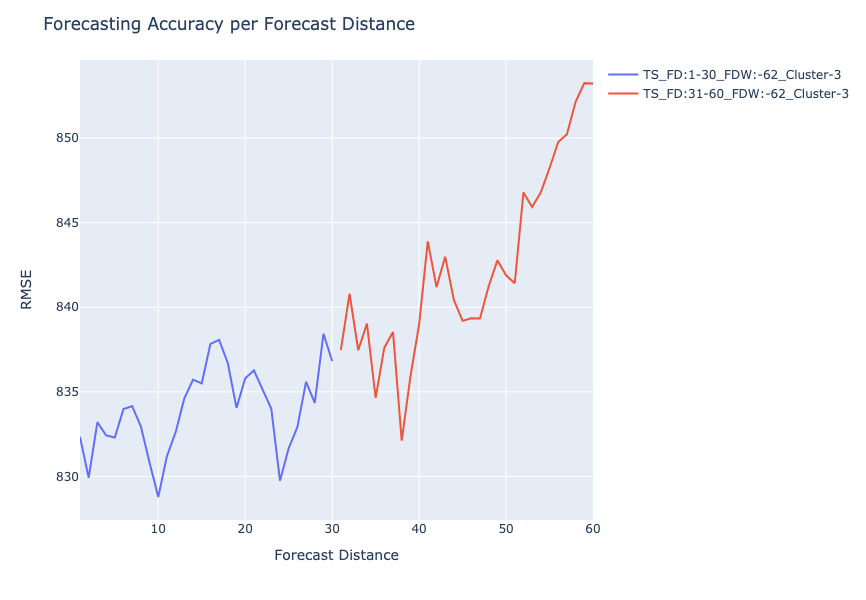

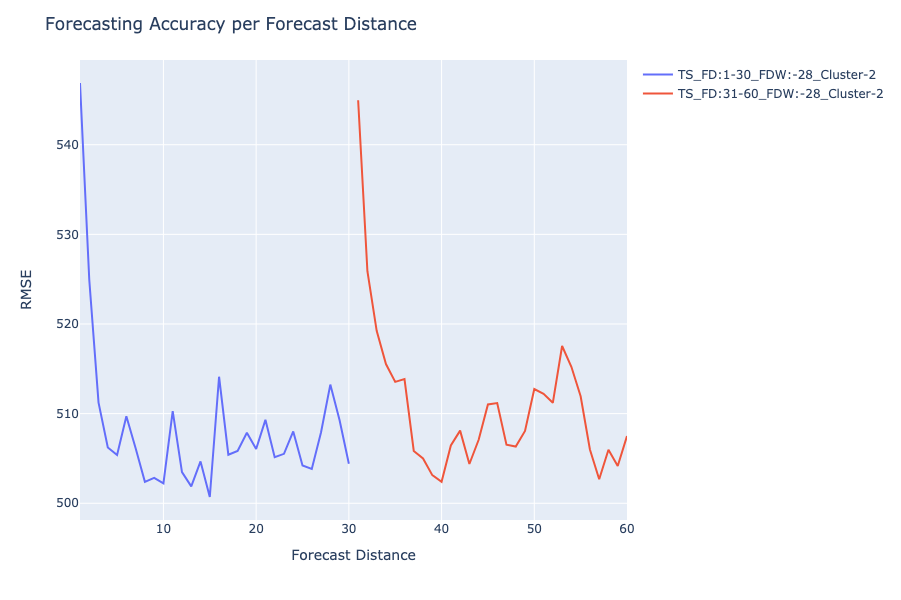

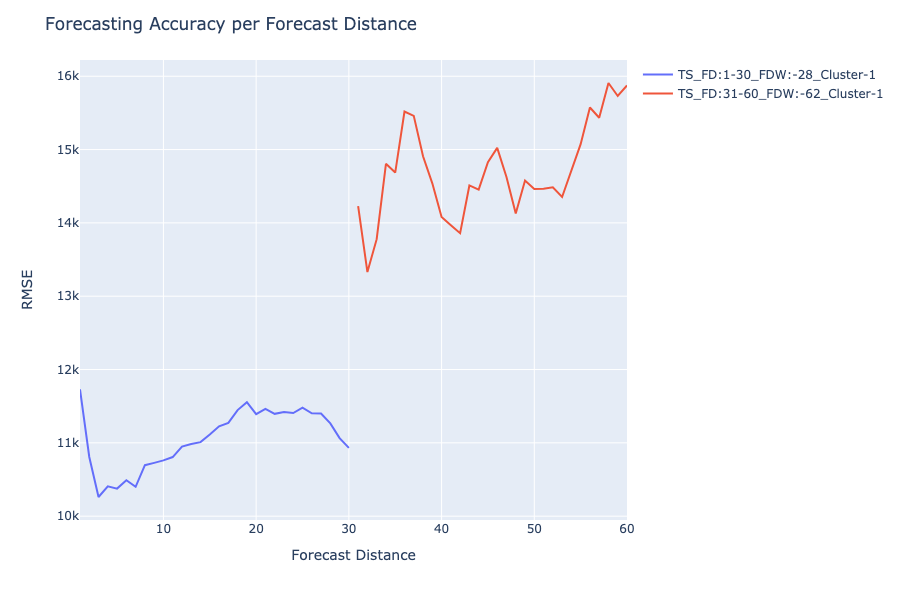

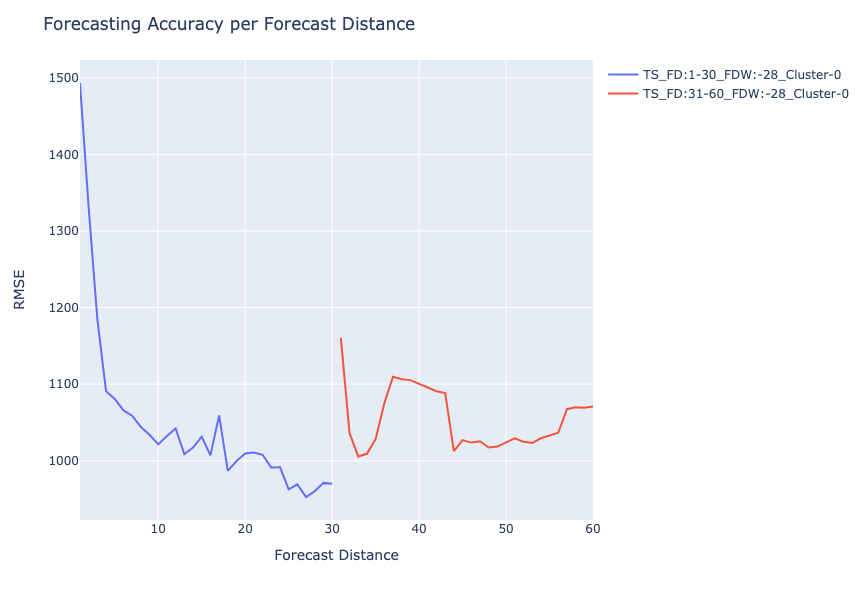

In [64]:
plot_fd_accuracy_by_cluster(df_w_clusters, project_scores, projects_best, ts_settings, data_subset='allBacktests', metric='RMSE')

### Now back to that problem cluster...how can we try to improve accuracy?

#### 1. Test out more models

#### 2. Retrain models with smaller feature lists

In [310]:
# 1. Test out more models
run_all_repository_models(projects_best) # Skip for now due to lack of API routes :(

Training blueprint 0 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 1 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 2 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 3 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 4 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 5 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 6 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 7 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 8 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 9 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 10 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 11 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 12 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 13 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 14 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 15 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Training blueprint 16 of 77 in TS_FD:1-7_FDW:-62_Cluster-2
Trainin

KeyboardInterrupt: 

In [66]:
# Create a new reduced features feature list per top model and retrain
train_reduced_features_models(projects_best, n_models=1, threshold=0.99, data_subset='allBacktests', include_blenders=True, metric='RMSE')
wait_for_jobs_to_process(projects_best)

Applying this threshold would result in a featurelist with no features
Applying this threshold would result in a featurelist with no features
Training AVG Blender on Featurelist Top 14 features M59
Training AVG Blender on Featurelist Top 20 features M61
Training Ridge Regressor with Forecast Distance Modeling and Series Scaling on Featurelist Top 251 features M12
Training AVG Blender on Featurelist Top 45 features M55
Training Light Gradient Boosting on ElasticNet Predictions  on Featurelist Top 5 features M43
Training Ridge Regressor with Forecast Distance Modeling on Featurelist Top 39 features M21
There are 5 jobs still processing
There are 2 jobs still processing
There are 1 jobs still processing
All jobs have finished processing...


In [68]:
compute_backtests(projects_best, n_models=5)
wait_for_jobs_to_process(projects_best)
get_cluster_acc(df_w_clusters, 
                 projects_best, 
                 ts_settings, 
                 data_subset='allBacktests', 
                 include_blenders=True, 
                 metric='RMSE', 
                 acc_calc=rmse)

All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-62_Cluster-3
All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-62_Cluster-3
Computing backtests for model 5e27b4e640bf2730f60d0125 in Project TS_FD:31-60_FDW:-28_Cluster-2
Computing backtests for model 5e27b4e640bf2730f60d011c in Project TS_FD:31-60_FDW:-28_Cluster-2
All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-28_Cluster-2
All available backtests have been submitted for scoring for project TS_FD:1-30_FDW:-28_Cluster-2
Computing backtests for model 5e27b566fbfc882f815a67d6 in Project TS_FD:31-60_FDW:-62_Cluster-1
All available backtests have been submitted for scoring for project TS_FD:31-60_FDW:-62_Cluster-1
Computing backtests for model 5e27b59409a2372f14160fd4 in Project TS_FD:1-30_FDW:-28_Cluster-1
Computing backtests for model 5e27b59409a2372f14160fcf in Project TS_FD:1-30_FDW:-28_Cluster-1
All available backtests have been 

Cluster         Sales  total_error
0       0   1053.510810  8516.716249
1       1  13044.670143  8516.716249
2       2    509.649496  8516.716249
3       3    838.195036  8516.716249

### Wohoo! Error is down! Now it's time to make predictions

In [95]:
#Get series and cluster pairs for predictions
series_to_clusters = series_to_clusters(df_w_clusters, ts_settings, split_col='Cluster')

In [97]:
# Load and prep scoring data
scoring_data = pd.read_csv('/Users/justin.swansburg/Downloads/time_series_poc_certification_all.csv')
scoring_data['Cluster'] = scoring_data[series_id].map(series_to_clusters)
scoring_data = create_cross_series_features(scoring_data, 
                                           group=[date_col,'Cluster'], 
                                           cols=[target,'Num_Customers'], 
                                           funcs=['mean','std'])
scoring_data[date_col] = pd.to_datetime(scoring_data[date_col])

In [98]:
clusters_to_series = clusters_to_series(df_w_clusters, ts_settings)
stats = get_project_stats(projects_best, n_models=1, cluster_to_series_map=clusters_to_series, metric='MAE')
stats

Project_Name                Project_ID Cluster    FD  FDW  \
0  TS_FD:1-60_FDW:-62_Cluster-3  5e164cca85047701107ef75c       3  1-60  -62   
1  TS_FD:1-60_FDW:-62_Cluster-2  5e164aad85047701107ef74c       2  1-60  -62   
2  TS_FD:1-60_FDW:-28_Cluster-1  5e16474af6fe7c011f41f0bc       1  1-60  -28   
3  TS_FD:1-60_FDW:-62_Cluster-0  5e164611f6fe7c011f41f0ac       0  1-60  -62   

                                          Model_Type  \
0  Zero-Inflated eXtreme Gradient Boosted Trees R...   
1  eXtreme Gradient Boosted Trees Regressor with ...   
2  Ridge Regressor with Forecast Distance Modelin...   
3  eXtreme Gradient Boosted Trees Regressor with ...   

                   Model_ID                                             Series  
0  5e164dd2d7006365e1dbeb65  [Beauty, Childrens Fashion, Mens Fashion, Wome...  
1  5e164d519b8e6f2d00ac00d0  [Beverages, Dairy, Cheese, and Eggs, Meat and ...  
2  5e180146b26a0c1f64c0d586  [Camera, Photo, and Video, Computer Parts and ...  
3  5e1744690991ff1247392f67  [Athletic Clothing, Bathing Suits, Lawn and Ga...

In [727]:
models_best = ts.get_top_models_from_projects(projects_best, n_models=1, data_subset='holdout', include_blenders=True, metric='MAE')

end_date = pd.to_datetime('10-31-2014')
forecast_point = pd.to_datetime('10-31-2014')
preds = get_or_request_predictions(models_best, 
                                   stats, 
                                   scoring_data, 
                                   start_date=None, 
                                   end_date=end_date, 
                                   forecast_point=forecast_point)


DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping')
Start Date:  2012-09-07 00:00:00+00:00
Uploading scoring dataset for Project TS_FD:1-60_FDW:-62_Cluster-0
Retraining M75 from 2012-09-07 00:00:00+00:00 to 2014-10-31 00:00:00 in Project TS_FD:1-60_FDW:-62_Cluster-0
Getting predictions for M81 in Project TS_FD:1-60_FDW:-62_Cluster-0

DatetimeModel('Ridge Regressor with Forecast Distance Modeling and Series Scaling')
Start Date:  2012-08-05 00:00:00+00:00
Uploading scoring dataset for Project TS_FD:1-60_FDW:-28_Cluster-1
Retraining M65 from 2012-08-05 00:00:00+00:00 to 2014-10-31 00:00:00 in Project TS_FD:1-60_FDW:-28_Cluster-1
Getting predictions for M120 in Project TS_FD:1-60_FDW:-28_Cluster-1

DatetimeModel('eXtreme Gradient Boosted Trees Regressor with Early Stopping')
Start Date:  2012-09-01 00:00:00+00:00
Uploading scoring dataset for Project TS_FD:1-60_FDW:-62_Cluster-2
Retraining M33 from 2012-09-01 00:00:00+00:00 to 2014-10-31 00:00:00 in Project TS_FD

In [728]:
xmas = set([x for x in pd.to_datetime(preds['timestamp']) if x.month == 12 and x.day == 25])
preds.loc[pd.to_datetime(preds['timestamp']).isin(xmas), 'prediction'] = 0
preds.head()

series_id               forecast_point  row_id  \
0  Beverages  2014-10-31T00:00:00.000000Z  944      
1  Beverages  2014-10-31T00:00:00.000000Z  945      
2  Beverages  2014-10-31T00:00:00.000000Z  946      
3  Beverages  2014-10-31T00:00:00.000000Z  947      
4  Beverages  2014-10-31T00:00:00.000000Z  948      

                     timestamp  forecast_distance    prediction  
0  2014-11-01T00:00:00.000000Z  1                  39264.747628  
1  2014-11-02T00:00:00.000000Z  2                  39526.823800  
2  2014-11-03T00:00:00.000000Z  3                  31834.171456  
3  2014-11-04T00:00:00.000000Z  4                  31744.751779  
4  2014-11-05T00:00:00.000000Z  5                  37084.236398

In [99]:
preds_and_actuals = merge_preds_and_actuals(preds, scoring_data, ts_settings)
mae(preds_and_actuals['prediction'],preds_and_actuals[target])


# The End...for now